## LAB Assignment
### Exercise Image Classifier(100 points )
Follow the above instructions of Image Classifier Training with PyTorch to train your own image classifier (using the [CIFAR10 dataset](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html). 

Please try to improve performance of classification by trying different network structures (add layers, modify parameters and so on) and different training strategies (loss function, optimizer and so on). 

In [1]:
import os
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
batch_size = 256

#### Load the Dataset

In [3]:
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4, padding_mode='reflect'), 
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10('./datasets/',
                                             train=True,
                                             transform=train_transform,
                                             download=True)
test_dataset = torchvision.datasets.CIFAR10('./datasets/',
                                            train=False,
                                            transform=test_transform,
                                            download=True)

# num_workers = os.cpu_count()
num_workers = 3

train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=num_workers)

test_loader = DataLoader(test_dataset,
                         batch_size=batch_size,
                         shuffle=False,
                         num_workers=num_workers)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

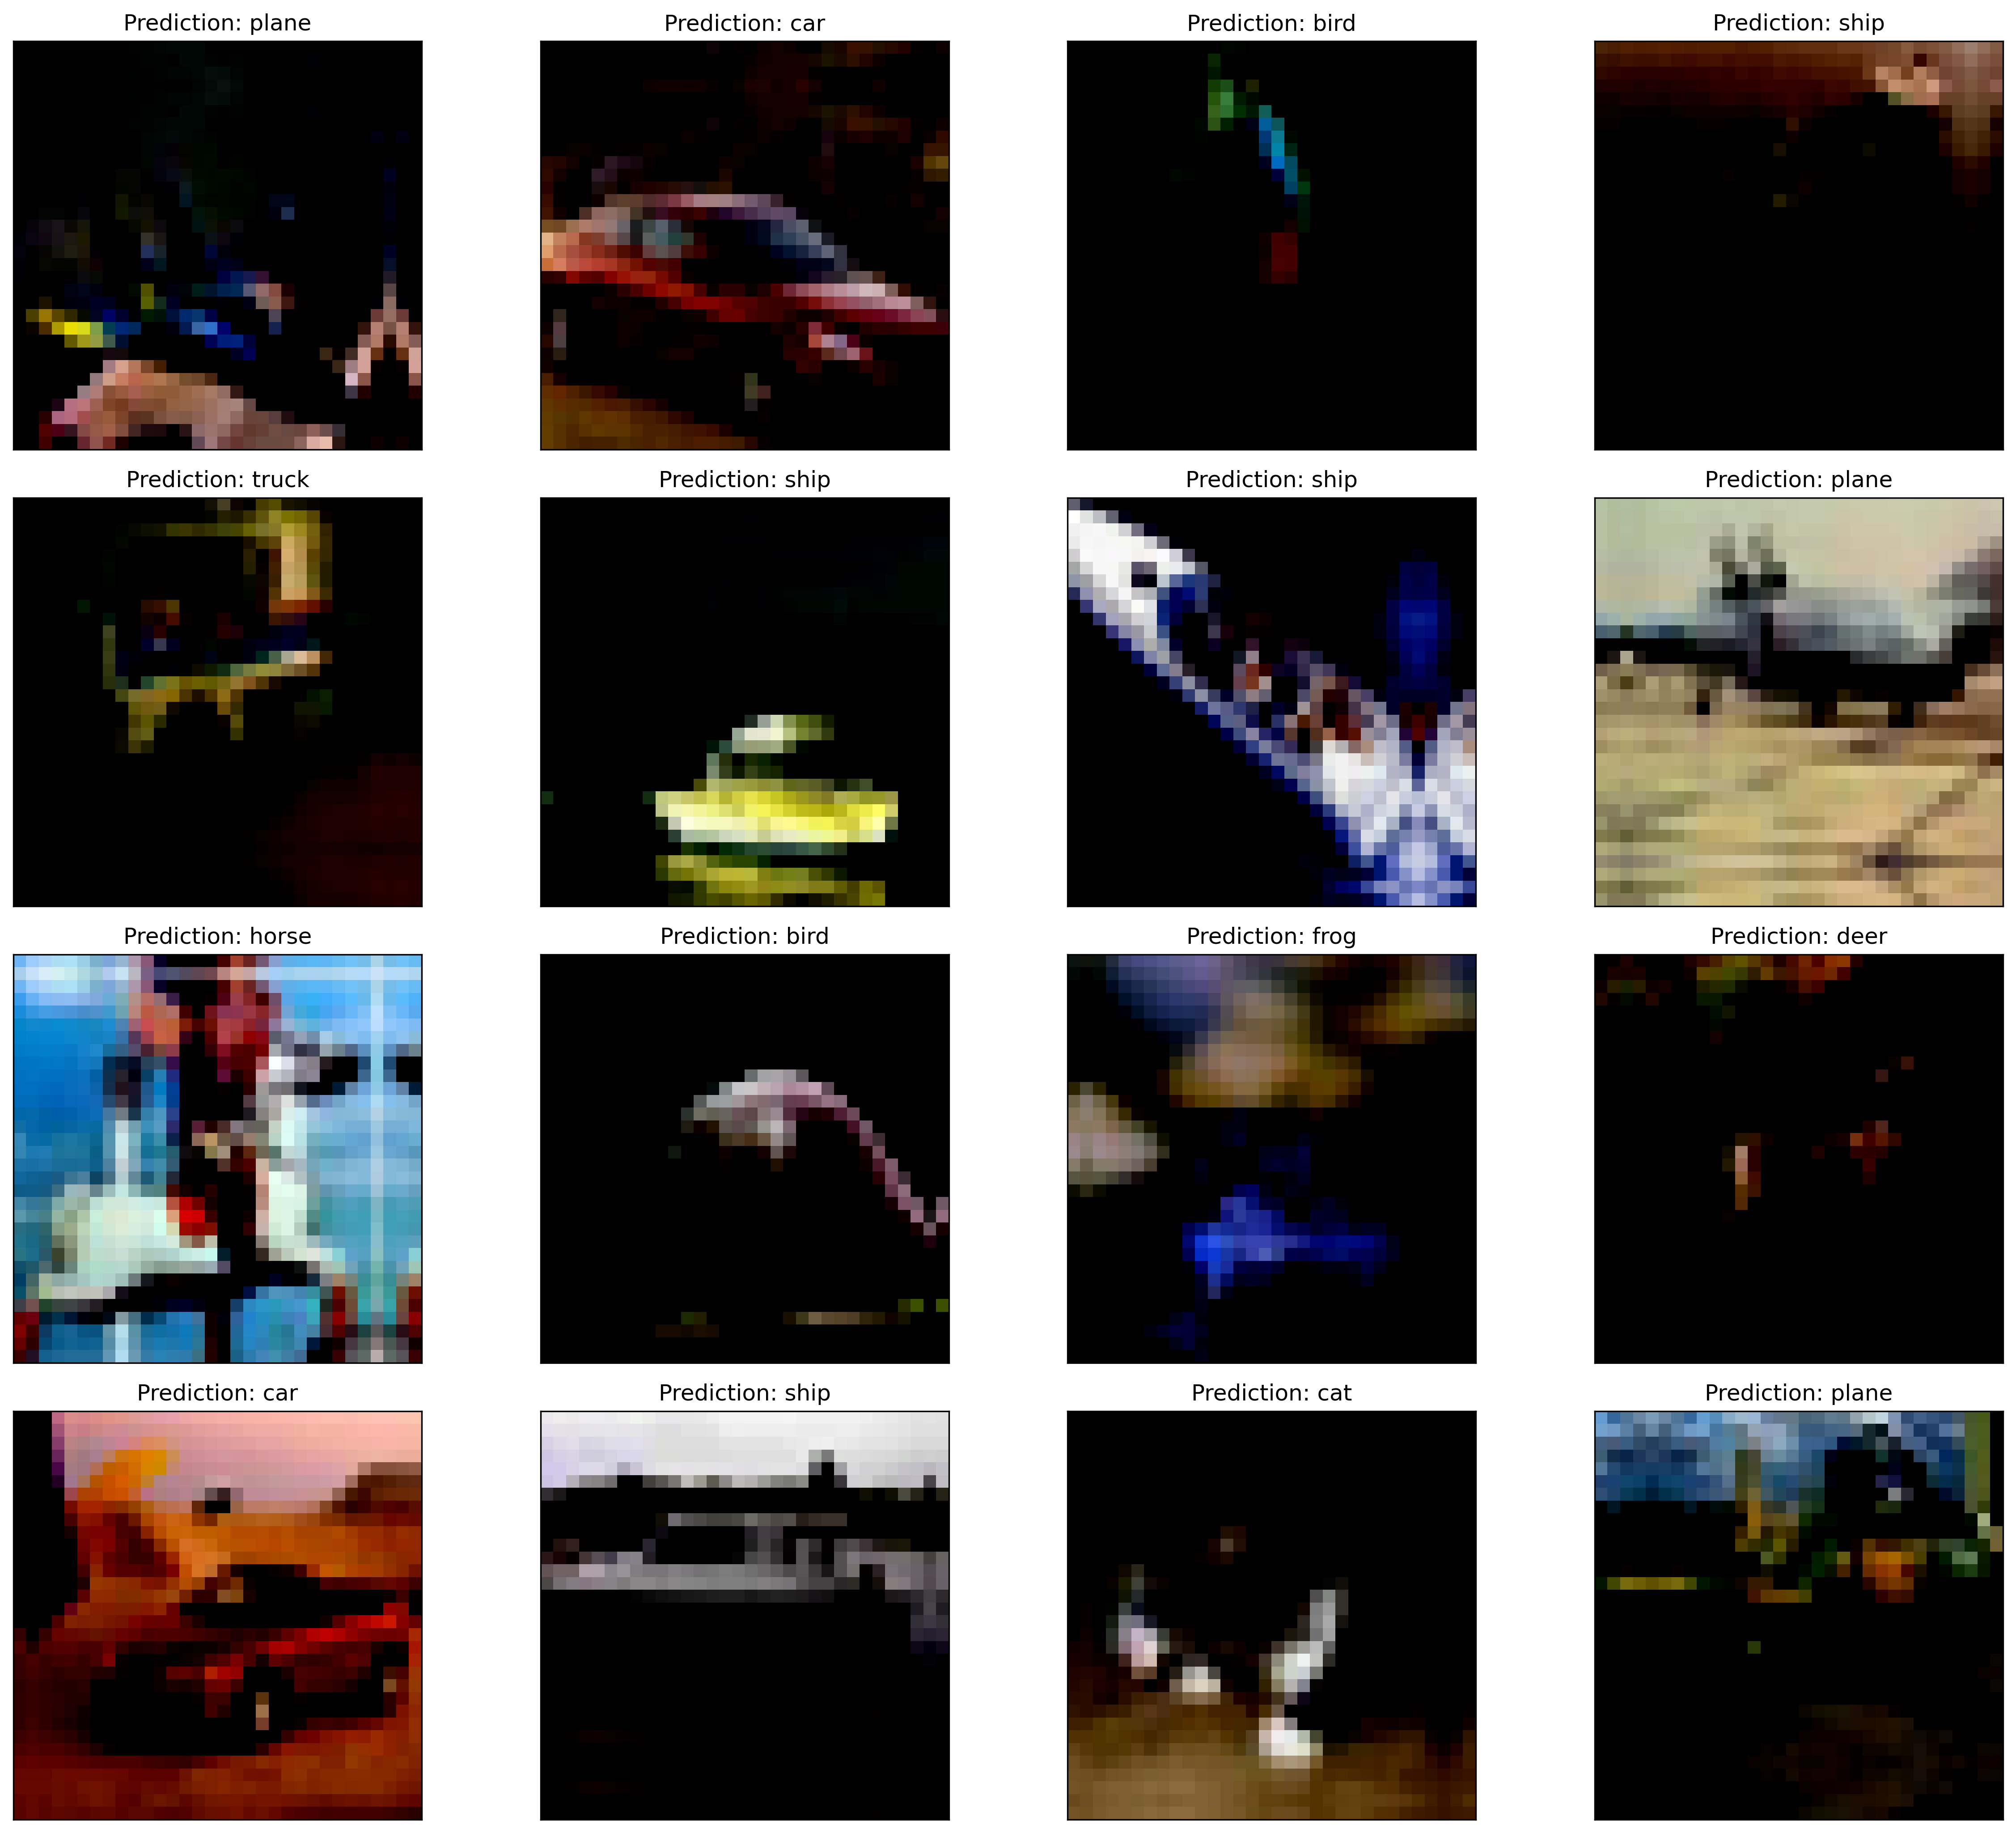

In [4]:
import matplotlib.pyplot as plt
import numpy as np

dataiter = iter(train_loader)
images,labels = next(dataiter)

fig=plt.figure(figsize=(16, 14), dpi=300)
for i in range(16):
  plt.subplot(4,4,i+1)
  plt.tight_layout()
  plt.imshow(images[i].permute(1, 2, 0))
  plt.title("Prediction: {}".format(
    classes[labels[i]]))
  plt.xticks([])
  plt.yticks([])

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class TrivialNet(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(in_features=16 * 5 * 5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = TrivialNet()
model

TrivialNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [6]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU()]
    if pool: layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    return nn.Sequential(*layers)

class ResNet9(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.conv1 = conv_block(3, 64)
        self.conv2 = conv_block(64, 128, True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, True)
        self.conv4 = conv_block(256, 512, True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), nn.Flatten(), nn.Linear(512, 10))
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [7]:
from tqdm import tqdm
import torch.optim as optim

n_epochs = 10
history = {'TrainLoss': [], 'TestLoss': [], 'TestAccuracy': []}
max_lr = 0.01

model = ResNet9()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),
                       lr=max_lr,
                       weight_decay=0.0001)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer,
                                          max_lr=max_lr,
                                          epochs=n_epochs,
                                          steps_per_epoch=len(train_loader))

In [8]:
for epoch in range(1, n_epochs + 1):
    model.train()
    progress_bar = tqdm(train_loader, unit='step')
    total_train_loss = 0.0
    correct = 0
    total_size = 0
    
    for step, (inputs, labels) in enumerate(progress_bar):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        
        nn.utils.clip_grad_value_(model.parameters(), 0.1)
        
        optimizer.step()
        optimizer.zero_grad()
        
        scheduler.step()
        
        predictions = torch.argmax(outputs, dim=1)
        local_accuracy = torch.sum(predictions == labels) / labels.shape[0]
        correct += torch.sum(predictions == labels)
        total_size += labels.size(0)
        
        total_train_loss += loss
        
        progress_bar.set_description("[%d/%d] Training; Loss: %.4f, Acc: %.4f" % 
                                    (epoch, n_epochs, loss.item(), local_accuracy.item()))
        
        if step == len(progress_bar) - 1:
            trainloss = total_train_loss / len(train_loader)
            accuracy = correct / total_size
            progress_bar.set_description("[%d/%d] Training; Loss: %.4f, Acc: %.4f" % 
                                    (epoch, n_epochs, trainloss.item(), accuracy.item()))
    progress_bar.close()
        
    model.eval()
    with torch.no_grad():
        tcorrect, total_test_loss = 0, 0
        total_size = 0
        progress_bar = tqdm(test_loader, unit='sample')
        for sample, (tinputs, tlabels) in enumerate(progress_bar):
            tinputs = tinputs.to(device)
            tlabels = tlabels.to(device)
            toutputs = model(tinputs)
            tloss = criterion(toutputs, tlabels)
            tpredictions = torch.argmax(toutputs, dim=1)
            total_size += tlabels.size(0)
            total_test_loss += tloss
            tcorrect += torch.sum(tpredictions == tlabels)
            
            progress_bar.set_description("[%d/%d] Testing;" % (epoch, n_epochs))
            
            if sample == len(progress_bar) - 1:
                taccuracy = tcorrect / total_size
                testloss = total_test_loss / len(test_loader)
                history['TrainLoss'].append(trainloss.item())
                history['TestLoss'].append(testloss.item())
                history['TestAccuracy'].append(taccuracy.item())
                
                progress_bar.set_description("[%d/%d] Testing; Test Loss: %.4f, Test Acc: %.4f" % 
                                        (epoch, n_epochs, testloss.item(), taccuracy.item()))
        progress_bar.close()

torch.save(model.state_dict(), 'models/cifar10.pth')

[1/10] Training; Loss: 1.2356, Acc: 0.5630: 100%|██████████| 196/196 [00:41<00:00,  4.69step/s]
[1/10] Testing; Test Loss: 1.3385, Test Acc: 0.5727: 100%|██████████| 40/40 [00:13<00:00,  2.95sample/s]
[2/10] Training; Loss: 0.9441, Acc: 0.6774: 100%|██████████| 196/196 [00:33<00:00,  5.93step/s]
[2/10] Testing; Test Loss: 1.8444, Test Acc: 0.4787: 100%|██████████| 40/40 [00:13<00:00,  2.90sample/s]
[3/10] Training; Loss: 0.8354, Acc: 0.7213: 100%|██████████| 196/196 [00:32<00:00,  6.09step/s]
[3/10] Testing; Test Loss: 0.8318, Test Acc: 0.7217: 100%|██████████| 40/40 [00:13<00:00,  3.04sample/s]
[4/10] Training; Loss: 0.6390, Acc: 0.7833: 100%|██████████| 196/196 [00:33<00:00,  5.92step/s]
[4/10] Testing; Test Loss: 0.7747, Test Acc: 0.7394: 100%|██████████| 40/40 [00:13<00:00,  2.96sample/s]
[5/10] Training; Loss: 0.5294, Acc: 0.8203: 100%|██████████| 196/196 [00:32<00:00,  6.01step/s]
[5/10] Testing; Test Loss: 0.9361, Test Acc: 0.7090: 100%|██████████| 40/40 [00:13<00:00,  2.95sampl

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

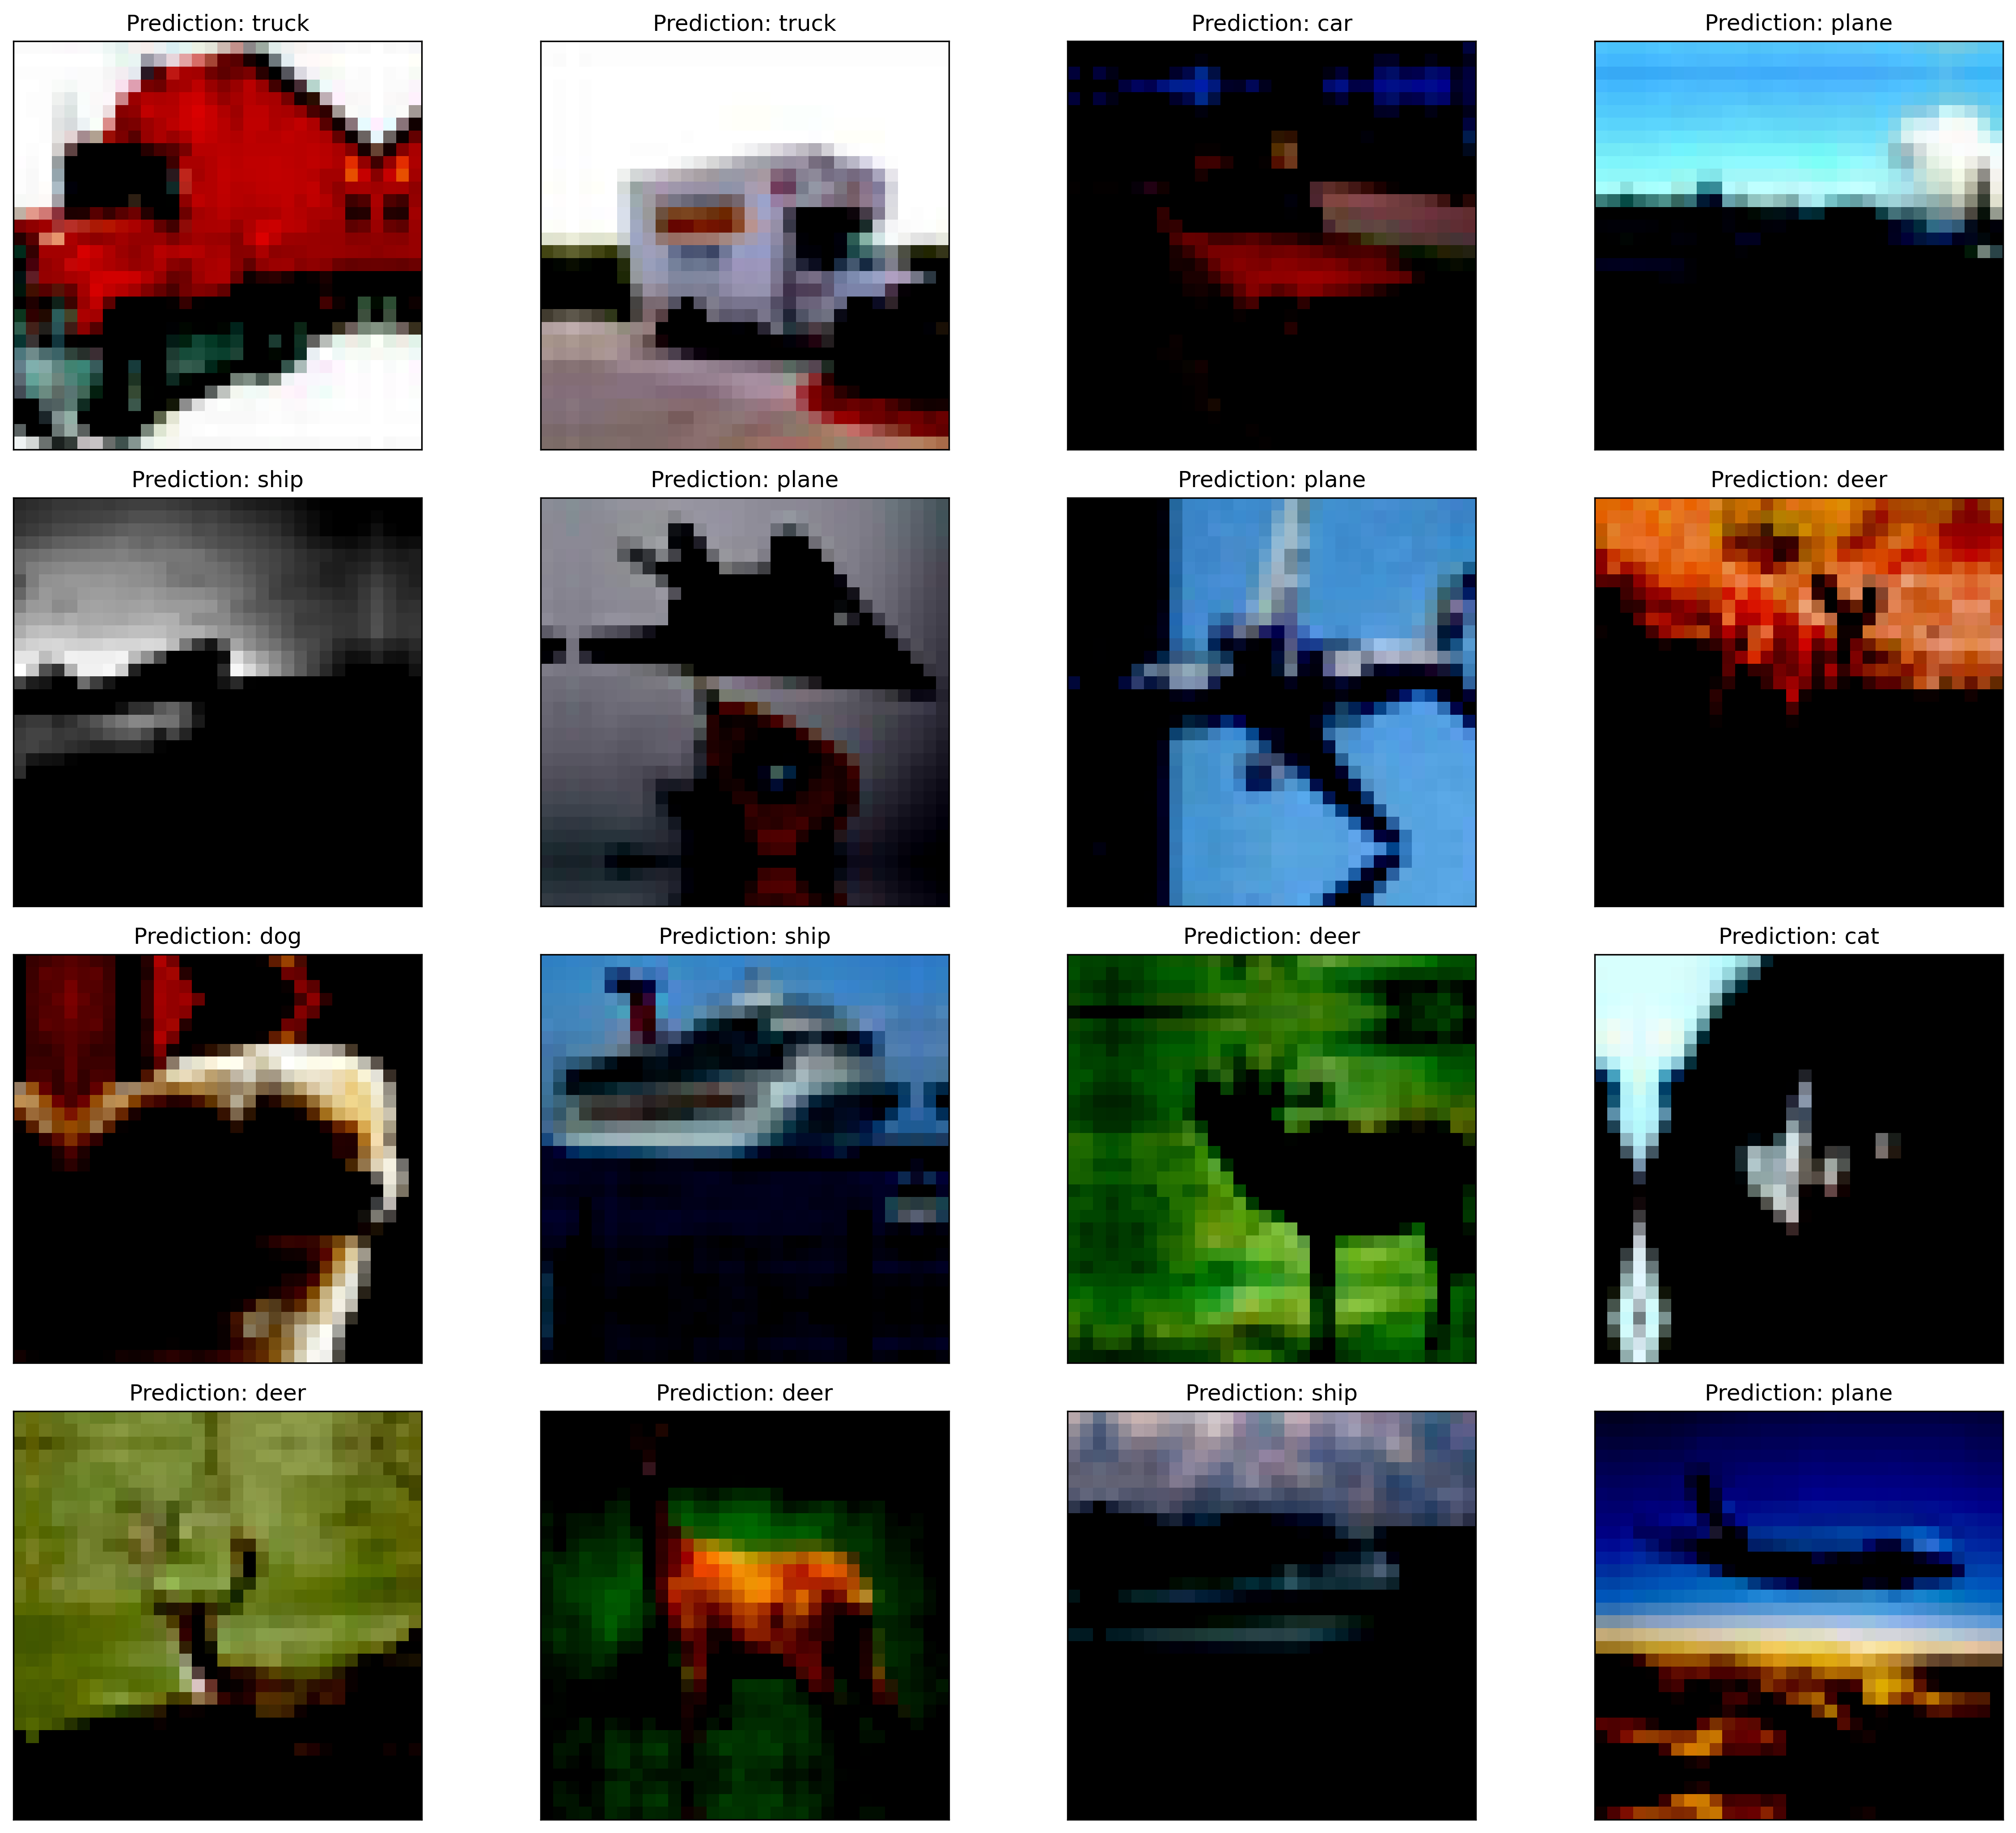

In [9]:
import matplotlib.pyplot as plt
import numpy as np

model.eval()
with torch.no_grad():
  dataiter = iter(train_loader)
  images, labels = next(dataiter)
  outputs = model(images.to(device))

  fig=plt.figure(figsize=(16, 14), dpi=300)
  for i in range(16):
    plt.subplot(4,4,i+1)
    plt.tight_layout()
    plt.imshow(images[i].permute(1, 2, 0))
    plt.title("Prediction: {}".format(
      classes[outputs.data.max(1, keepdim=True)[1][i].item()]))
    plt.xticks([])
    plt.yticks([])